In [1]:
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd

def clean_file_name(name):
    return ''.join(c if c.isalnum() or c in {'_', '-'} else '_' for c in name)

def contains_keywords(position_name):
    keywords = ['anal', 'data', 'scientist']
    return any(keyword in position_name.lower() for keyword in keywords)

def count_technology_occurrences(html_content, technologies):
    occurrences = {tech: html_content.lower().count(tech.lower()) for tech in technologies}
    return occurrences

def fetch_job_offer_pages(base_url, technologies, page_range):
    page_occurrences_list = []  # List to store occurrences for each page

    for page_number in page_range:
        current_url = f"{base_url}&page={page_number}"

        response = requests.get(current_url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            job_links = soup.select('a.link-primary[data-link="jd-detail"]')

            page_occurrences = {tech: 0 for tech in technologies}  # Initialize occurrences for the current page

            for index, link in enumerate(job_links, 1):
                job_url = link['href']
                position_name = link.get_text(strip=True)

                if not contains_keywords(position_name):
                    print(f"Ignoring job offer page {page_number} - Position: {position_name} (Does not contain relevant keywords)")
                    continue

                clean_position_name = clean_file_name(position_name)

                print(f"Fetching job offer page {page_number} - Position: {position_name}: {job_url}")

                job_response = requests.get(job_url)

                if job_response.status_code == 200:
                    job_html = job_response.text

                    with open(f'job_{page_number}_{index}_{clean_position_name}.html', 'w', encoding='utf-8') as file:
                        file.write(job_html)

                    tech_occurrences = count_technology_occurrences(job_html, technologies)

                    for tech in technologies:
                        if tech_occurrences[tech] > 0:
                            page_occurrences[tech] += 1

            page_occurrences_list.append(page_occurrences)

            print(f"\nTotal occurrences on page {page_number} (counted once per technology):")
            print(page_occurrences)

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")

    # Create a DataFrame from the list of page occurrences
    total_occurrences_df = pd.DataFrame(page_occurrences_list, columns=technologies)

    # Print the total occurrences across all pages
    print("\nTotal occurrences across all pages:")
    total_technology_occurrences = total_occurrences_df.sum()
    print(total_technology_occurrences)

    # Create separate variables for each technology's total occurrences
    python_total_occurrences = total_technology_occurrences['Python']
    power_bi_total_occurrences = total_technology_occurrences['Power BI']
    sql_total_occurrences = total_technology_occurrences['SQL']
    excel_total_occurrences = total_technology_occurrences['Excel']

    return total_occurrences_df, python_total_occurrences, power_bi_total_occurrences, sql_total_occurrences, excel_total_occurrences

base_url = "https://beta.www.jobs.cz/prace/?q%5B%5D=analytik"
technologies_to_count = ['Python', 'Power BI', 'SQL', 'Excel']
page_range_to_analyze = range(1, 41)

total_occurrences_df, python_total_occurrences, power_bi_total_occurrences, sql_total_occurrences, excel_total_occurrences = fetch_job_offer_pages(
    base_url, technologies_to_count, page_range_to_analyze)



Ignoring job offer page 1 - Position: Interní auditor/ka (Does not contain relevant keywords)
Ignoring job offer page 1 - Position: Product Designer / UX Designer pro zadávání pracovních inzerátů – třeba na Jobs.cz (Does not contain relevant keywords)
Ignoring job offer page 1 - Position: Senior Risk Manager (Does not contain relevant keywords)
Ignoring job offer page 1 - Position: Obchodník v K&L Rock! (Does not contain relevant keywords)
Fetching job offer page 1 - Position: Functional Analyst OneSumX Senior: https://beta.www.jobs.cz/rpd/1634626874/?searchId=d68eaabc-c27d-498f-91e0-de5efae4c971&rps=233
Fetching job offer page 1 - Position: Analytik CRM - Power BI (Praha - Čakovice): https://beta.www.jobs.cz/rpd/1628784192/?searchId=d68eaabc-c27d-498f-91e0-de5efae4c971&rps=233
Fetching job offer page 1 - Position: Sales Analytik (m/ž): https://beta.www.jobs.cz/rpd/1626178915/?searchId=d68eaabc-c27d-498f-91e0-de5efae4c971&rps=233
Fetching job offer page 1 - Position: Business Analytik 

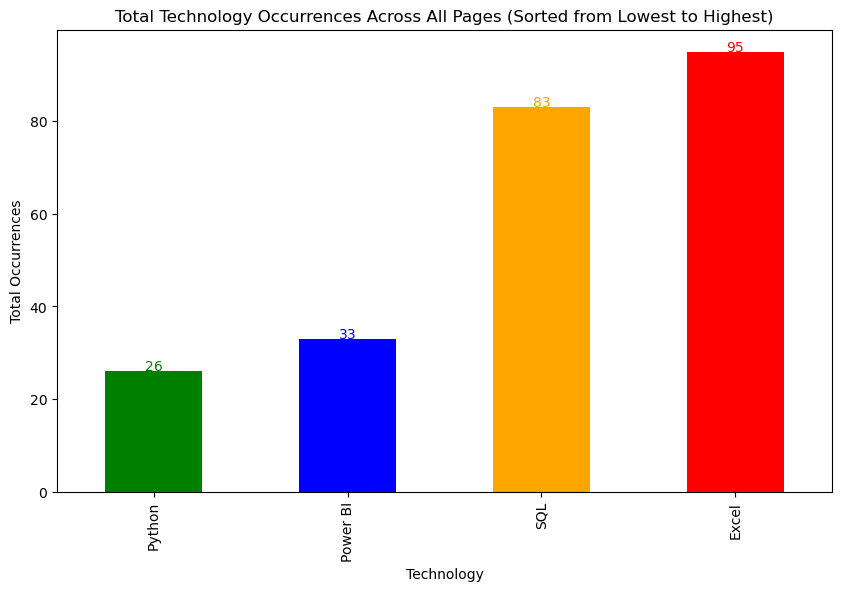

In [2]:
import matplotlib.pyplot as plt

# Assuming total_occurrences_df is your DataFrame
# If not, replace it with your actual DataFrame variable

# Calculate the total occurrences for each technology
total_technology_occurrences = total_occurrences_df.sum()

# Sort technologies based on total occurrences (from lowest to highest)
sorted_technologies = total_technology_occurrences.sort_values(ascending=True)

# Set the figure size
plt.figure(figsize=(10, 6))

# Define different colors for each technology
colors = ['green', 'blue', 'orange', 'red']

# Plot the bar chart with different colors for each technology
ax = sorted_technologies.plot(kind='bar', color=colors)

# Add text labels with numbers in the color of the corresponding bar
for i, value in enumerate(sorted_technologies):
    ax.text(i, value + 0.1, str(value), color=colors[i], ha='center')

# Add labels and title
plt.xlabel('Technology')
plt.ylabel('Total Occurrences')
plt.title('Total Technology Occurrences Across All Pages (Sorted from Lowest to Highest)')

# Show the plot
plt.show()

